# Image Segmentation

This is the training process of an image segmentation model. It includes: data preparation, model construction, model training, model evaluation and model testing.

In [1]:
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [4]:
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

In [5]:
#for directory_path in glob.glob('D:\\PneumothoraxDetection\\siim-raw\\train-dataset\\train_png\\train_images'):
#for directory_path in glob.glob('D:\\PneumothoraxDetection\\siim-raw\\train-dataset\\mask_png\\masks'):

## Data preparation

In [6]:
# Prepare training data
train_images = []
for directory_path in glob.glob('D:\\PneumothoraxDetection\\siim-raw\\train-dataset\\train_raw_png_part2'):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        train_images.append(img)

        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

(1041, 128, 128)


In [7]:
# Prepare training mask data
train_masks = [] 
for directory_path in glob.glob('D:\\PneumothoraxDetection\\siim-raw\\train-dataset\\mask_raw_png_part2'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        #print(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)

(1041, 128, 128)


In [8]:
import tensorflow as tf
sess = tf.Session()

In [9]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
#Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 

In [10]:
X.shape
Y.shape  #（X.shape : same）

(1041, 128, 128)

In [11]:
#X = cv2.resize(X, (128, 1))
#Y = cv2.resize(Y, (128, 1))

In [12]:
X = np.expand_dims(X, axis=3)
X.shape

(1041, 128, 128, 1)

In [13]:
Y = np.expand_dims(Y, axis=3)
Y.shape

(1041, 128, 128, 1)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

In [15]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [16]:
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [17]:
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model

## Build unet model

In [18]:
def build_unet(shape):
    input_layer = Input(shape = shape)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

In [19]:
# define model
model = build_unet((128, 128, 1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [21]:
from keras import backend as K

In [22]:
model.summary()
model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = [dice_coef, 'binary_accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Train the model

In [23]:
history=model.fit(x_train, 
          y_train,
          batch_size=10, 
          epochs=30,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 728 samples, validate on 313 samples
Epoch 1/30
728/728 [==============================] - 125s 172ms/sample - loss: -0.6423 - dice_coef: 0.6435 - binary_accuracy: 0.0169 - val_loss: -0.6667 - val_dice_coef: 0.6576 - val_binary_accuracy: 0.0153
Epoch 2/30
728/728 [==============================] - 128s 176ms/sample - loss: -0.6653 - dice_coef: 0.6635 - binary_accuracy: 0.0190 - val_loss: -0.6349 - val_dice_coef: 0.6210 - val_binary_accuracy: 0.0264
Epoch 3/30
728/728 [==============================] - 123s 169ms/sample - loss: -0.7009 - dice_coef: 0.7024 - binary_accuracy: 0.0392 - val_loss: -0.6445 - val_dice_coef: 0.6489 - val_binary_accuracy: 0.0540
Epoch 4/30
728/728 [==============================] - 121s 167ms/sample - loss: -0.6965 - dice_coef: 0.6975 - binary_accuracy: 0.0878 - val_loss: -0.7154 - val_dice_coef: 0.7170 - val_binary_accuracy: 0.1255
Epoch 5/30
728/728 [==============================] - 123s 169ms/sample - loss: -0.7444 - dice_coef: 0.7436 - binary_accur

## Evaluate the model

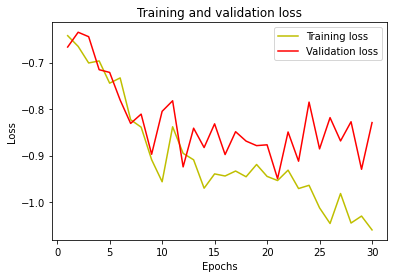

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.getcwd()+'\static\model\seg-loss.png')
plt.show()

dict_keys(['loss', 'dice_coef', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_binary_accuracy'])


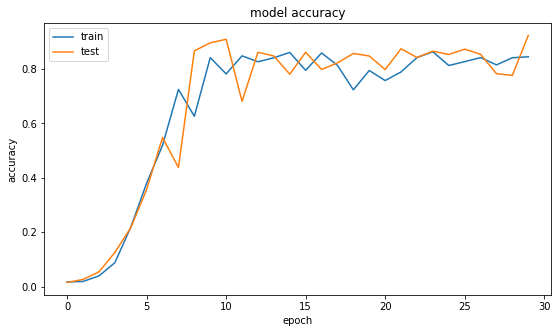

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.getcwd()+'\static\model\seg-accuracy.png')

In [ ]:
#model.save('unet-seg-03.h5')

In [ ]:
from tensorflow import keras
#model = keras.models.load_model('unet-seg-03.h5', compile=False)

## Test the model

In [ ]:
test_img = cv2.imread('D:\\PneumothoraxDetection\\siim-raw\\train-dataset\\train_raw_png_part2\\1.2.276.0.7230010.3.1.4.8323329.31712.1517875156.434784.png', cv2.IMREAD_COLOR)       
plt.imshow(test_img, cmap='gray')
#print(test_img)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

In [ ]:
test_img.reshape(1,128,128,1)

In [ ]:
test_img = np.expand_dims(test_img, axis=3)
test_img.shape

In [ ]:
prediction = model.predict(test_img)

In [ ]:
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image.squeeze(), cmap='bone')  #Reds

In [ ]:
plt.imsave('D:\\PneumothoraxDetection\\siim-raw\\train-dataset\\train_png\\train_prediction_results\\mask_result.png', prediction_image, cmap='gray')

In [ ]:
#def bounding_box(img):
#    # return max and min of a mask to draw bounding box
#    rows = np.any(img, axis=1)
#    cols = np.any(img, axis=0)
#    rmin, rmax = np.where(rows)[0][[0, -1]]
#    cmin, cmax = np.where(cols)[0][[0, -1]]
#    
#    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax

In [ ]:
#def plot_imgs(n,df):
#    for i in range(n):
#        #idx = np.random.randint(0,df.shape[0])
#        #tmp = df.iloc[idx]
#        # path of file
        #path = tmp['filepath']
        #encoding = tmp['EncodedPixels']
        #image = pydicom.dcmread(path).pixel_array
#        fig, axes = plt.subplots(1,4, figsize=(20,15))
#        axes[0].imshow(test_img, cmap='bone')
#        axes[0].set_title('Image')
#        mask = rle2mask(encoding,image.shape[0],image.shape[1])
#        axes[1].imshow(prediction_image,cmap='gray')
#        axes[1].set_title('Mask')
#        axes[2].imshow(test_img,cmap='bone')
#        axes[2].imshow(prediction_image,alpha=0.3,cmap='Reds')
#        axes[2].set_title('Image + mask')
#        rmin, cmin, rmax, cmax = bounding_box(mask)
#        image_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#        cv2.rectangle(image_rgb, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
#        axes[3].imshow(image_rgb)
#        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
#        axes[3].set_title('Image Box Annoted')
#        plt.show()

In [ ]:
#tmp = 
#plot_imgs(15,tmp)